<h1>Uber Surge Pricing: A breakdown of pricing per census tract in DC.</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

# Below are cells that process the *original* Uber data up until and including a cell that demonstrates the nature of the bug. 

(Original data available from our Google Drive: https://drive.google.com/folderview?id=0B-mutxqHY34rblhORk9raWxQQjQ&usp=sharing)

In [2]:
uberFeb = pd.read_csv('~/Documents/CJL/Uber/TractsSurgeDC2_Feb4_Mar2.csv', parse_dates=['timestamp'], dayfirst=True, usecols=['timestamp', 'surge_multiplier',
                                                                                    'expected_wait_time','product_type',
                                                                                      'start_location_id']) 

In [3]:
print(uberFeb.head())
print(uberFeb.shape)

            timestamp  surge_multiplier  expected_wait_time product_type  start_location_id
0 2016-02-03 22:18:26               1.0                 300     uberTAXI                 40
1 2016-02-03 22:18:26               1.0                 300      UberSUV                 40
2 2016-02-03 22:18:26               1.0                 300    UberBLACK                 40
3 2016-02-03 22:18:26               1.5                 180        uberX                 40
4 2016-02-03 22:18:26               1.7                 480       uberXL                 40
(53695775, 5)


**Remove `uberTAXI` because they don't have surge pricing**

In [4]:
uberFeb = uberFeb[uberFeb.product_type != 'uberTAXI']

In [5]:
uberFeb.rename(columns={'start_location_id':'location_id'}, inplace=True)

In [6]:
uberFeb[uberFeb.location_id.isnull()]   # only show rows where continent is missing

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id


**Find incomplete days at the head and tail ends of the time frame**

In [7]:
uberFeb.head()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
1,2016-02-03 22:18:26,1.0,300,UberSUV,40
2,2016-02-03 22:18:26,1.0,300,UberBLACK,40
3,2016-02-03 22:18:26,1.5,180,uberX,40
4,2016-02-03 22:18:26,1.7,480,uberXL,40
5,2016-02-03 22:18:26,1.0,480,SUV + Car Seat,40


In [8]:
uberFeb.tail()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
53695770,2016-03-03 08:36:26,1.0,240,UberSUV,255
53695771,2016-03-03 08:36:26,1.0,240,UberBLACK,255
53695772,2016-03-03 08:36:26,2.1,480,uberX + Car Seat,255
53695773,2016-03-03 08:36:26,2.1,240,uberX,255
53695774,2016-03-03 08:36:26,1.0,360,uberXL,255


**Chop off incomplete days from each end of timeseries**

In [9]:
uberFeb = uberFeb[(uberFeb.timestamp >'2016-02-03') & (uberFeb.timestamp < '2016-03-03')]

## The bug resulted in more than one row representing a single product (eg. uberX) at any given location ID and timestamp. This should not happen, as each location ID for each product should only have one row per timestamp. 

## The existance of duplicates is found with the code below

In [10]:
tmp = uberFeb[uberFeb.product_type == 'uberX']
tmp['duplicates'] = tmp.duplicated(subset=['timestamp', 'location_id'])

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
if True in tmp.duplicates.unique():
    print("Duplicates")
else: print("No Duplicates!")

Duplicates


In [12]:
tmp.duplicates.value_counts()

False    3715161
True     3170672
Name: duplicates, dtype: int64

_____

# Below is the analysis of data that was collected after the bug in `gatherUberData.py` was fixed.

<h2>Read in Uber data</h2>
### The two compressed CSV files are available from our Google Drive:
* TractsSurgeDC3.csv : https://drive.google.com/file/d/0B-mutxqHY34rOGZpV0pxem1aYzQ/view?usp=sharing
* TractsSurgeDC3-Dec26.csv : https://drive.google.com/file/d/0B-mutxqHY34rdFhCZGkwaWM1LW8/view?usp=sharing

Data are in two files because data collection was interrupted due to server errors. 

In [13]:
cols = ['timestamp', 'surge_multiplier','expected_wait_time','product_type','start_location_id']
uber1 = pd.read_csv('./data/TractsSurgeDC3.csv',
                    parse_dates=['timestamp'], 
                    dayfirst=True, 
                    usecols=cols) 

uber2 = pd.read_csv('./data/TractsSurgeDC3-Dec26.csv',
                    parse_dates=['timestamp'], 
                    dayfirst=True, 
                    usecols=cols) 

In [14]:
print(uber1.shape)
print(uber2.shape)

(12812115, 5)
(16204625, 5)


<h2>Uber Data Preprocessing</h2>

**Remove `uberTAXI` because they don't have surge pricing**

In [15]:
uber1 = uber1[uber1.product_type != 'uberTAXI']
uber2 = uber2[uber2.product_type != 'uberTAXI']

**Shorten the location id header**

In [16]:
uber1.rename(columns={'start_location_id':'location_id'}, inplace=True)
uber2.rename(columns={'start_location_id':'location_id'}, inplace=True)

#### Find incomplete days at the head and tail ends of the time frame

In [17]:
uber1.head()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
0,2016-11-14 20:21:30,1.0,1440.0,uberX + Car Seat,4.0
1,2016-11-14 20:21:30,1.0,420.0,uberX,4.0
2,2016-11-14 20:21:30,1.0,600.0,uberXL,4.0
3,2016-11-14 20:21:30,1.0,420.0,POOL,4.0
4,2016-11-14 20:21:30,1.0,240.0,UberSUV,37.0


In [18]:
uber1.tail()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
12812110,2016-11-28 19:30:30,1.0,360.0,UberBLACK,104.0
12812111,2016-11-28 19:30:30,1.0,480.0,uberX + Car Seat,104.0
12812112,2016-11-28 19:30:30,1.0,120.0,uberX,104.0
12812113,2016-11-28 19:30:30,1.0,180.0,uberXL,104.0
12812114,2016-01-01 00:00:00,NaN,NaN,NaN,NaN


#### Chop off those incomplete days from each end of timeseries

In [19]:
uber1 = uber1[(uber1.timestamp >'2016-11-15') & (uber1.timestamp < '2016-11-28')] #include 15th, exclude 28th. Need extra Mon Tue to make even

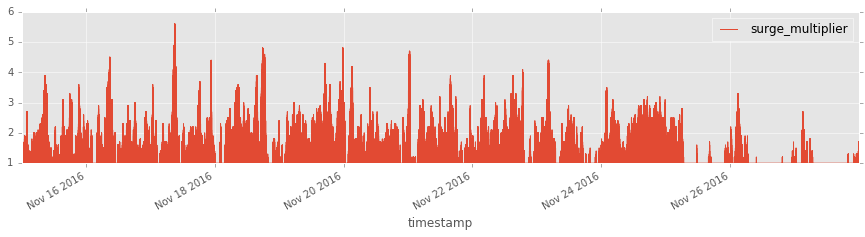

In [20]:
uber1.plot(x='timestamp', y='surge_multiplier') # days including 15th -> all 27th (12 days)

In [21]:
uber2.head()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
0,2016-12-08 09:11:39,1.0,420,UberSUV,51.0
1,2016-12-08 09:11:39,1.0,1200,Wheelchair,51.0
2,2016-12-08 09:11:39,1.0,420,UberBLACK,51.0
3,2016-12-08 09:11:39,1.0,780,uberX + Car Seat,51.0
4,2016-12-08 09:11:39,1.0,180,uberX,51.0


In [22]:
uber2.tail()

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id
16204620,2016-12-26 01:08:39,1.0,240,POOL,262.0
16204621,2016-12-26 01:08:39,1.0,480,UberSUV,271.0
16204622,2016-12-26 01:08:39,1.0,300,UberBLACK,271.0
16204623,2016-12-26 01:08:39,1.0,120,uberX,271.0
16204624,2016-12-26 01:08:39,1.0,240,uber,NaN


In [23]:
uber2 = uber2[(uber2.timestamp >'2016-12-09') & (uber2.timestamp < '2016-12-23')] # include 9th, exclude 23th so we have 
# 4 of each day represnted except Monday where we have 3

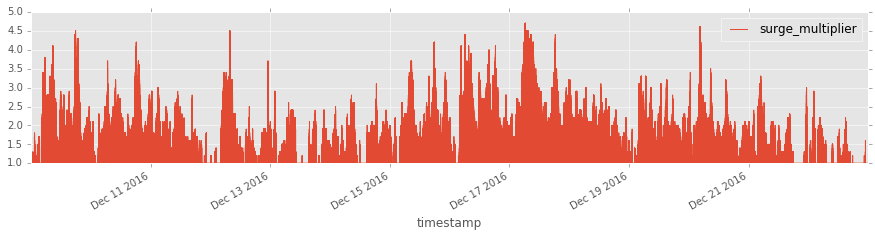

In [24]:
uber2.plot(x='timestamp', y='surge_multiplier')

**Check for null rows, and remove them if they exist**

In [25]:
uber1[uber1.location_id.isnull()]   # only show rows where continent is missing

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id


In [26]:
uber1.dropna(how='all', inplace=True)

In [27]:
uber2[uber2.location_id.isnull()]   # only show rows where continent is missing

,timestamp,surge_multiplier,expected_wait_time,product_type,location_id


In [28]:
uber2.dropna(how='all', inplace=True)

#### Concatenate dataframes

In [29]:
dfs = [uber1, uber2]
uber = pd.concat(dfs)
print(uber.shape)
print(uber.head())

(23744631, 5)
                 timestamp  surge_multiplier  expected_wait_time      product_type  location_id
116122 2016-11-15 00:00:30               1.0              1440.0  uberX + Car Seat         11.0
116123 2016-11-15 00:00:30               1.0               360.0             uberX         11.0
116124 2016-11-15 00:00:30               1.0               360.0              POOL         11.0
116125 2016-11-15 00:00:30               1.0              1560.0  uberX + Car Seat         10.0
116126 2016-11-15 00:00:30               1.0               420.0             uberX         10.0


#### Check there are no record repeats, defined as more than one row for a Location_id for one timestamp, which was an issue in the original version of this study

In [30]:
tmp = uber[uber.product_type == 'uberX']
tmp['duplicates'] = tmp.duplicated(subset=['timestamp', 'location_id'])

if True in tmp.duplicates.unique():
    print("Duplicates present")
else: print("No Duplicates")

No Duplicates


/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Visualize the final dataset timeseries

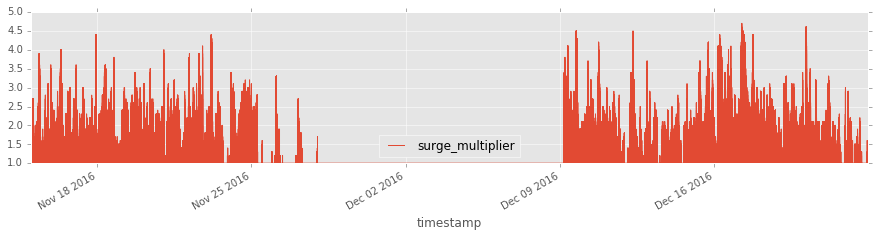

In [31]:
uber[uber.product_type == 'uberX'].plot(x='timestamp', y='surge_multiplier')

In [32]:
# Lets save this timeseries in case we want it later:
uber.to_csv('./data/uber.csv')

<h2>Uber Calculations to aggregate across time, for each location, for each product type:</h2>
* **'`Location id`'** for each of the 276 locations across DC
* **'`product`'** for each of the 8 Uber car product types
* **'`proportion`'** of time each '`location_id`' had surging
* **'`mean_expected_waitTime`'** averaging the expected wait time for each '`product`' at each '`location_id`'
* **'`mean_expected_waitTime_surge`'** same as above, but only considering surge time
* **'`num_surgeMultiplierSamples`'** gets the number of pings that come back with surge prices for each '`product`' at each '`location_id`'
* **'`sum_surgeMultiplierSamples`'** sums up the value of the surge multipliers for each '`product`' at eaech '`location_id`' 

Any number in the '`surge_multiplier`' column above '1' means it is surging. 

In [33]:
def surge_proportion(df, product, i):
    
    tmp_dict = {}
    tmp = df[df.location_id == i]
    
    tmp_dict['location_id'] = i
    tmp_dict['product'] = product
    tmp_dict['proportion'] = (len(tmp[(tmp.product_type == product) & (tmp.surge_multiplier !=1)]) / \
                              len(tmp[tmp.product_type == product]))*100
    tmp_dict['mean_expected_waitTime'] = np.mean(tmp.expected_wait_time[tmp.product_type == product])
    tmp_dict['mean_expected_waitTime_surge'] = np.mean(tmp.expected_wait_time[(tmp.product_type == product) & \
                                                                              (tmp.surge_multiplier != 1)])
    tmp_dict['num_surgeMultiplierSamples'] = len(tmp.surge_multiplier[(tmp.product_type == product) & \
                                                                      (tmp.surge_multiplier !=1)])
    tmp_dict['sum_surgeMultiplierSamples'] = sum(tmp.surge_multiplier[(tmp.product_type == product) & \
                                                                      (tmp.surge_multiplier !=1)])
    
    return tmp_dict

In [34]:
products =  ['uberXL','BLACK CAR + Car Seat','SUV + Car Seat','UberBLACK','UberSUV','uberX','uberX + Car Seat']
props = []   #append each temp_dict returned to this list

In [35]:
def get_surge_proportions(df, products):
    for p in products:
        for i in range(276):
            props.append(surge_proportion(df, p, i))      

get_surge_proportions(uber, products)

In [36]:
uberAgg = pd.DataFrame(props)   # turn list of temp_dicts into a dataframe

** Now data is aggregated across time, for each location, for each product type**

In [37]:
uberAgg.head()

,location_id,mean_expected_waitTime,mean_expected_waitTime_surge,num_surgeMultiplierSamples,product,proportion,sum_surgeMultiplierSamples
0,0,546.502852,584.347826,184,uberXL,2.018429,290.5
1,1,823.243334,886.153846,169,uberXL,1.412689,271.7
2,2,693.050083,770.877193,171,uberXL,1.427379,273.2
3,3,518.424933,572.441860,172,uberXL,1.921358,268.5
4,4,498.174655,534.545455,220,uberXL,2.407529,337.3


<h2>Read in Geo/Census data</h2>

* ** Uber data is collected from 276 locations across DC**
* **while Census Tract-related data ('`geodata`'), such as Poverty, is collected at the tract level (179 locations)**

* **Therefore, we need to reduce the uber dataframe to that of the census-related dataframes by averaging together locations within a tract:**

* **To connect Uber data (which only has '`location_id`') with Census data (which only has 11-digit number '`GEOID`' which identifies the tract) we need to use an intermediary dataframe `'baseDF`'**

* ** `baseDF` was created when the '`location_id`' were all originally created and validated (eg. not in water, not in parks - all valid addresses). It contains all the data pertaining to the 276 locations (longitude, latitude, location_id, and other geographical identifiers including `Block` which is a longer version of `GEOID` tract number.**
* ** The `location_id` will be used to connect `baseDF` with `uberSurgeDataAgg` DF**
* ** In turn, the `Block` number in `baseDF` will be shortened to match '`GEOID`' and used to connect the `uberSurgeDataAgg` (which has 276 locations) with the `geodata` `GEOID` tract numbers (which has 179 locations). **

## Read in '`baseDF`'

In [38]:
baseDF = pd.read_pickle('./data/baseDF.pkl') # 1 row for each 276 locations where Uber data is collected

In [39]:
baseDF.columns

Index(['Block', 'State', 'address', 'latitude', 'latlong', 'location_id', 'longitude', 'tracts'], dtype='object')

** Add a `GEOID` column containing the first 11 digits from `Block`**

In [40]:
baseDF['GEOID'] = 0
# Add 'geoid' column to baseDF to match or 'merge' with geodata.GEOID
def add_geoid(cols):
    return str(cols[:11])
baseDF['GEOID'] = baseDF.Block.apply(add_geoid)

** We only need two columns, so lets get rid of the others.**

In [41]:
baseDF = baseDF[['GEOID', 'location_id']]

In [42]:
baseDF.head()

,GEOID,location_id
0,11001010900,0
1,11001007301,1
2,11001009807,2
3,11001009802,3
4,11001009700,4


In [43]:
baseDF['GEOID'] = baseDF['GEOID'].astype(int)

In [44]:
type(baseDF['GEOID'][0])

numpy.int64

## Read in '`geodata`'

Data from https://www.census.gov

In [45]:
geo_cols = ['BASENAME', 'GEOID', 'POP100', 'AREALAND']
geodata = pd.read_csv('./data/geodata.csv', usecols=geo_cols) # 1 row for each tract
geodata = geodata.sort_values('GEOID')

In [46]:
geodata.head()

,AREALAND,BASENAME,GEOID,POP100
138,1868613,1.00,11001000100,4890
139,542460,2.01,11001000201,3916
127,803422,2.02,11001000202,5425
84,1010815,3.00,11001000300,6233
132,1532717,4.00,11001000400,1455


<h1> Merging data</h1>

In [47]:
# MERGE uberSurgeDataAgg with baseDF -> both have 0-276 location_ids, but uber has (276 Locations * 7 products)
baseDF_uberAgg = pd.merge(baseDF, uberAgg, on='location_id')

In [48]:
# MERGE the above with the geodata dataset that has one row per tract
geodata_baseDF_uberAgg = pd.merge(geodata, baseDF_uberAgg, on='GEOID')

In [49]:
geodata_baseDF_uberAgg.head()

,AREALAND,BASENAME,GEOID,POP100,location_id,mean_expected_waitTime,mean_expected_waitTime_surge,num_surgeMultiplierSamples,product,proportion,sum_surgeMultiplierSamples
0,1868613,1.0,11001000100,4890,40,269.748060,309.156118,1422,uberXL,11.373270,2343.2
1,1868613,1.0,11001000100,4890,40,327.521108,540.000000,8,BLACK CAR + Car Seat,0.075894,12.6
2,1868613,1.0,11001000100,4890,40,336.182011,NaN,0,SUV + Car Seat,0.000000,0.0
3,1868613,1.0,11001000100,4890,40,209.553903,276.000000,10,UberBLACK,0.077447,15.6
4,1868613,1.0,11001000100,4890,40,225.018709,NaN,0,UberSUV,0.000000,0.0


** Now, for tracts that have multiple `location_ids`, to average those points together for each product type separately, so that each tract is represented once for each product type.**

In [50]:
def merge_ids_toTracts(tmp):
        
    tmp_dict = {}
    tmp_dict['BASENAME'] = tmp.BASENAME.iloc[0]
    tmp_dict['GEOID'] = tmp.GEOID.iloc[0]
    tmp_dict['POP100'] = tmp.POP100.iloc[0]
    tmp_dict['location_id'] = tmp.location_id
    tmp_dict['Uproduct'] = tmp['product'].iloc[0]
    tmp_dict['proportion'] = np.mean(tmp.proportion)
    tmp_dict['mean_expected_waitTime'] = np.mean(tmp.mean_expected_waitTime)
    tmp_dict['mean_expected_waitTime_surge'] = np.mean(tmp.mean_expected_waitTime_surge)
    tmp_dict['mean_surge_multiplier'] = (sum(tmp.sum_surgeMultiplierSamples))/(sum(tmp.num_surgeMultiplierSamples))
            
    return tmp_dict

In [51]:
consolidated_tracts = []
def get_merged_locations(df, product_list):
    for i in df.GEOID.unique():
        for p in product_list:
            tmp = df[(df.GEOID == i) & (df['product']==p)]
            consolidated_tracts.append(merge_ids_toTracts(tmp))
        
get_merged_locations(geodata_baseDF_uberAgg, products)

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


In [52]:
mean_tractsDF = pd.DataFrame(consolidated_tracts)

In [53]:
mean_tractsDF

,BASENAME,GEOID,POP100,Uproduct,location_id,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion
0,1.00,11001000100,4890,uberXL,"0 40 7 55 Name: location_id, dtype: int64",278.148692,317.789441,1.639545,11.591108
1,1.00,11001000100,4890,BLACK CAR + Car Seat,"1 40 8 55 Name: location_id, dtype: int64",334.685647,525.000000,1.618750,0.076214
2,1.00,11001000100,4890,SUV + Car Seat,"2 40 9 55 Name: location_id, dtype: int64",341.819737,NaN,NaN,0.000000
3,1.00,11001000100,4890,UberBLACK,"3 40 10 55 Name: location_id, dtype: int64",214.583794,323.000000,1.568182,0.085268
4,1.00,11001000100,4890,UberSUV,"4 40 11 55 Name: location_id, dtype: int64",229.903507,NaN,NaN,0.000000
5,1.00,11001000100,4890,uberX,"5 40 12 55 Name: location_id, dtype: int64",210.208902,256.759398,1.590044,26.124719
6,1.00,11001000100,4890,uberX + Car Seat,"6 40 13 55 Name: location_id, dtype: int64",806.084546,949.708997,1.564019,22.919313
7,2.01,11001000201,3916,uberXL,"14 54 Name: location_id, dtype: int64",330.765707,380.086580,1.652670,11.338351
8,2.01,11001000201,3916,BLACK CAR + Car Seat,"15 54 Name: location_id, dtype: int64",401.297297,570.000000,1.466667,0.063593
9,2.01,11001000201,3916,SUV + Car Seat,"16 54 Name: location_id, dtype: int64",405.031063,NaN,NaN,0.000000


<h2>Preprocessing Census Data</h2>
* **Get census data pertaining to:**
    - Poverty -> percent of people below the poverty line in each tract.
    - Household Income -> Median household income in dollars $$ for each tract.
    - Race/Ethnicity -> Percentage of each race within each tract.
* All census data from 2014

<h2>Poverty</h2>

<h4>Poverty columns of interest:</h4>
* Open './Census_data/Poverty/metadata.json' in text editor eg. Atom to find names of columns of interest

* Goal is to find %age total population in each tract living in poverty.
    - "geoid" = used to allow merging with other tables later.
    - "B17001001" = "Total"
    - "B17001002" = "Income in the past 12 months below poverty level

In [54]:
columns = ['geoid', 'B17001001', 'B17001002']
poverty = pd.read_csv('./Census_data/Poverty/acs2014_5yr_B17001_14000US11001007403.csv',skiprows=[1,2,3], usecols=columns)
poverty.head()

,geoid,B17001001,B17001002
0,14000US11001000100,5184,123
1,14000US11001000201,81,70
2,14000US11001000202,3597,710
3,14000US11001000300,6079,729
4,14000US11001000400,1509,145


In [55]:
#Create empty column for percentage calculation
poverty['percent_poverty'] = 0.0

In [56]:
def get_percentages(df):
    for index, i in enumerate(df['B17001002']):
        poverty.percent_poverty[index] = ((i/(df.B17001001[index]))*100)
get_percentages(poverty)

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


In [57]:
poverty.head()

,geoid,B17001001,B17001002,percent_poverty
0,14000US11001000100,5184,123,2.372685
1,14000US11001000201,81,70,86.419753
2,14000US11001000202,3597,710,19.738671
3,14000US11001000300,6079,729,11.992104
4,14000US11001000400,1509,145,9.609013


** The contents of '`geoid`' column has 7 extra alphanumerics at the beginning. Create a new column to match the '`geodata.GEOID`' column, populate it with '`geoid`' with first 7 removed, and '`pd.merge`' on it.**

In [58]:
def add_GEOID(cols):
    return str(cols[7:])

def merge_geodata(geodata, tmp):
    tmp['GEOID'] = tmp['GEOID'].astype(int)
    return pd.merge(geodata, tmp, on='GEOID')

In [59]:
poverty['GEOID'] = poverty.geoid.apply(add_GEOID)
poverty.head()

,geoid,B17001001,B17001002,percent_poverty,GEOID
0,14000US11001000100,5184,123,2.372685,11001000100
1,14000US11001000201,81,70,86.419753,11001000201
2,14000US11001000202,3597,710,19.738671,11001000202
3,14000US11001000300,6079,729,11.992104,11001000300
4,14000US11001000400,1509,145,9.609013,11001000400


In [60]:
tmp = poverty[['GEOID', 'percent_poverty']]
tmp.head()

,GEOID,percent_poverty
0,11001000100,2.372685
1,11001000201,86.419753
2,11001000202,19.738671
3,11001000300,11.992104
4,11001000400,9.609013


In [61]:
tmp['GEOID'] = tmp['GEOID'].astype(int)
geodata = pd.merge(geodata, tmp, on='GEOID')
geodata.head()

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,AREALAND,BASENAME,GEOID,POP100,percent_poverty
0,1868613,1.00,11001000100,4890,2.372685
1,542460,2.01,11001000201,3916,86.419753
2,803422,2.02,11001000202,5425,19.738671
3,1010815,3.00,11001000300,6233,11.992104
4,1532717,4.00,11001000400,1455,9.609013


<h2>Household Income</h2>

<h4>Household Income columns of interest:</h4>
* Get median household income per tract using data obtained from 'American FactFinder'

http://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t#none

In [62]:
columns = ['GEO.id2', 'HC01_VC85']
medianHouseholdIncome = pd.read_csv('./Census_data/ACS_14_5YR_DP03/ACS_14_5YR_DP03.csv', skiprows=[1,2],usecols=columns)

In [63]:
medianHouseholdIncome.rename(columns={'GEO.id2':'GEOID', 'HC01_VC85': 'medianHouseholdIncome'}, inplace=True)
medianHouseholdIncome.head()

,GEOID,medianHouseholdIncome
0,11001000100,170338.0
1,11001000201,NaN
2,11001000202,152256.0
3,11001000300,135045.0
4,11001000400,225179.0


In [64]:
geodata = merge_geodata(geodata, medianHouseholdIncome)
geodata.head()

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome
0,1868613,1.00,11001000100,4890,2.372685,170338.0
1,542460,2.01,11001000201,3916,86.419753,NaN
2,803422,2.02,11001000202,5425,19.738671,152256.0
3,1010815,3.00,11001000300,6233,11.992104,135045.0
4,1532717,4.00,11001000400,1455,9.609013,225179.0


<h2>Race/Ethnicity</h2>
* Get data for white + Hispanic White and People of Color (including Black/African American, Asian, Hispanic Black, and Hispanic Asian):
    - "B03002001" = "Total"
    - "B03002003" = "White alone"
    - "B03002004" = "Black or African American alone"
    - "B03002006" = "Asian alone"
    - "B03002013" = "Hispanic or Latino - White alone"
    - "B03002014" = "Hispanic or Latino - Black or African American alone"
    - "B03002016" = "Asian alone"

In [65]:
columns = ['geoid', 'B03002001', 'B03002003', 'B03002004', 'B03002006', 'B03002013', 'B03002014', 'B03002016']
raceEthnicity = pd.read_csv('./Census_data/Race_Ethnicity/acs2014_5yr_B03002_14000US11001007403.csv',\
                            skiprows=[1,2,3],usecols=columns)

In [66]:
raceEthnicity.head()

,geoid,B03002001,B03002003,B03002004,B03002006,B03002013,B03002014,B03002016
0,14000US11001000100,5184,4359,44,301,375,0,0
1,14000US11001000201,3844,2535,379,506,201,23,11
2,14000US11001000202,4551,3825,172,205,179,0,26
3,14000US11001000300,6079,4947,57,395,328,17,0
4,14000US11001000400,1527,1025,85,121,209,8,0


In [67]:
raceEthnicity['percent_white'] = 0.0
raceEthnicity['percent_POC'] = 0.0

def get_raceEthnicity_percentages(df):
    for index, i in enumerate(df['B03002001']):
        raceEthnicity.percent_white[index] = (((df.B03002003[index]+df.B03002013[index])/df.B03002001[index]) * 100)
        raceEthnicity.percent_POC[index] = (((df.B03002004[index]+df.B03002006[index]+df.B03002014[index]\
                                              +df.B03002016[index])/df.B03002001[index]) * 100)

get_raceEthnicity_percentages(raceEthnicity)

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in long_scalars
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in long_scalars


In [68]:
raceEthnicity.head()

,geoid,B03002001,B03002003,B03002004,B03002006,B03002013,B03002014,B03002016,percent_white,percent_POC
0,14000US11001000100,5184,4359,44,301,375,0,0,91.319444,6.655093
1,14000US11001000201,3844,2535,379,506,201,23,11,71.175858,23.907388
2,14000US11001000202,4551,3825,172,205,179,0,26,87.980664,8.855197
3,14000US11001000300,6079,4947,57,395,328,17,0,86.774140,7.715085
4,14000US11001000400,1527,1025,85,121,209,8,0,80.812050,14.014407


In [69]:
raceEthnicity['GEOID'] = raceEthnicity.geoid.apply(add_GEOID)
raceEthnicity.head()

,geoid,B03002001,B03002003,B03002004,B03002006,B03002013,B03002014,B03002016,percent_white,percent_POC,GEOID
0,14000US11001000100,5184,4359,44,301,375,0,0,91.319444,6.655093,11001000100
1,14000US11001000201,3844,2535,379,506,201,23,11,71.175858,23.907388,11001000201
2,14000US11001000202,4551,3825,172,205,179,0,26,87.980664,8.855197,11001000202
3,14000US11001000300,6079,4947,57,395,328,17,0,86.774140,7.715085,11001000300
4,14000US11001000400,1527,1025,85,121,209,8,0,80.812050,14.014407,11001000400


In [70]:
tmp = raceEthnicity[['GEOID', 'percent_white', 'percent_POC']]
tmp.head()

,GEOID,percent_white,percent_POC
0,11001000100,91.319444,6.655093
1,11001000201,71.175858,23.907388
2,11001000202,87.980664,8.855197
3,11001000300,86.774140,7.715085
4,11001000400,80.812050,14.014407


In [71]:
geodata = merge_geodata(geodata, tmp)
geodata.head()

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC
0,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093
1,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388
2,803422,2.02,11001000202,5425,19.738671,152256.0,87.980664,8.855197
3,1010815,3.00,11001000300,6233,11.992104,135045.0,86.774140,7.715085
4,1532717,4.00,11001000400,1455,9.609013,225179.0,80.812050,14.014407


<h1>More Merging!</h1>

In [72]:
mean_tractsDF.head()

,BASENAME,GEOID,POP100,Uproduct,location_id,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion
0,1.0,11001000100,4890,uberXL,"0 40 7 55 Name: location_id, dtype: int64",278.148692,317.789441,1.639545,11.591108
1,1.0,11001000100,4890,BLACK CAR + Car Seat,"1 40 8 55 Name: location_id, dtype: int64",334.685647,525.000000,1.618750,0.076214
2,1.0,11001000100,4890,SUV + Car Seat,"2 40 9 55 Name: location_id, dtype: int64",341.819737,NaN,NaN,0.000000
3,1.0,11001000100,4890,UberBLACK,"3 40 10 55 Name: location_id, dtype: int64",214.583794,323.000000,1.568182,0.085268
4,1.0,11001000100,4890,UberSUV,"4 40 11 55 Name: location_id, dtype: int64",229.903507,NaN,NaN,0.000000


In [73]:
geodata.head()

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC
0,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093
1,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388
2,803422,2.02,11001000202,5425,19.738671,152256.0,87.980664,8.855197
3,1010815,3.00,11001000300,6233,11.992104,135045.0,86.774140,7.715085
4,1532717,4.00,11001000400,1455,9.609013,225179.0,80.812050,14.014407


In [74]:
#remove unnecessary columns
del mean_tractsDF['BASENAME']
del mean_tractsDF['location_id']
del mean_tractsDF['POP100']

In [75]:
mean_tractsDF.head()

,GEOID,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion
0,11001000100,uberXL,278.148692,317.789441,1.639545,11.591108
1,11001000100,BLACK CAR + Car Seat,334.685647,525.000000,1.618750,0.076214
2,11001000100,SUV + Car Seat,341.819737,NaN,NaN,0.000000
3,11001000100,UberBLACK,214.583794,323.000000,1.568182,0.085268
4,11001000100,UberSUV,229.903507,NaN,NaN,0.000000


In [76]:
# MERGE the above with the geodata dataset that has one row per tract
mean_tractsDF_census = pd.merge(geodata, mean_tractsDF, on="GEOID")

In [77]:
mean_tractsDF_census

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion
0,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,uberXL,278.148692,317.789441,1.639545,11.591108
1,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,BLACK CAR + Car Seat,334.685647,525.000000,1.618750,0.076214
2,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,SUV + Car Seat,341.819737,NaN,NaN,0.000000
3,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,UberBLACK,214.583794,323.000000,1.568182,0.085268
4,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,UberSUV,229.903507,NaN,NaN,0.000000
5,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,uberX,210.208902,256.759398,1.590044,26.124719
6,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,uberX + Car Seat,806.084546,949.708997,1.564019,22.919313
7,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388,uberXL,330.765707,380.086580,1.652670,11.338351
8,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388,BLACK CAR + Car Seat,401.297297,570.000000,1.466667,0.063593
9,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388,SUV + Car Seat,405.031063,NaN,NaN,0.000000


<h1>Exploratory Visualizations and Correlations</h1>

In [78]:
from scipy.stats import pearsonr
import seaborn as sns

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [79]:
mean_tractsDF_census.isnull().sum()

AREALAND                          0
BASENAME                          0
GEOID                             0
POP100                            0
percent_poverty                   7
medianHouseholdIncome            21
percent_white                     7
percent_POC                       7
Uproduct                          0
mean_expected_waitTime            0
mean_expected_waitTime_surge    339
mean_surge_multiplier           339
proportion                        0
dtype: int64

<h2>Poverty Stats</h2>

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


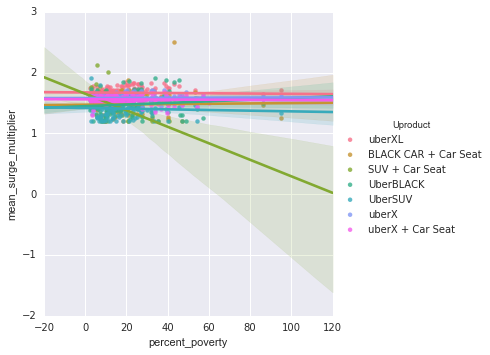

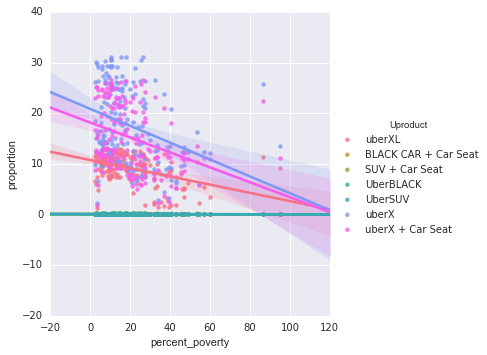

In [80]:
sns.lmplot(y='mean_surge_multiplier', x='percent_poverty', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='proportion', x='percent_poverty', hue="Uproduct",data=mean_tractsDF_census)

In [81]:
## What does this look like when we remove 2 outlier tracts?

y1 = mean_tractsDF_census.dropna().mean_surge_multiplier[(mean_tractsDF_census['BASENAME'] !=68.04) & \
                                                         (mean_tractsDF_census['BASENAME'] != 2.01)]
x1 = mean_tractsDF_census.dropna().percent_poverty[(mean_tractsDF_census['BASENAME'] !=68.04) & \
                                                   (mean_tractsDF_census['BASENAME'] != 2.01)]

y2 = mean_tractsDF_census.dropna().proportion[(mean_tractsDF_census['BASENAME'] !=68.04) & \
                                              (mean_tractsDF_census['BASENAME'] != 2.01)]
x2 = mean_tractsDF_census.dropna().percent_poverty[(mean_tractsDF_census['BASENAME'] !=68.04) & \
                                                   (mean_tractsDF_census['BASENAME'] != 2.01)]

print(pearsonr(x1, y1))
print(pearsonr(x2,y2))

(0.039730168445319895, 0.23428573504297456)
(-0.10404024241593651, 0.0017970602543457782)


/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


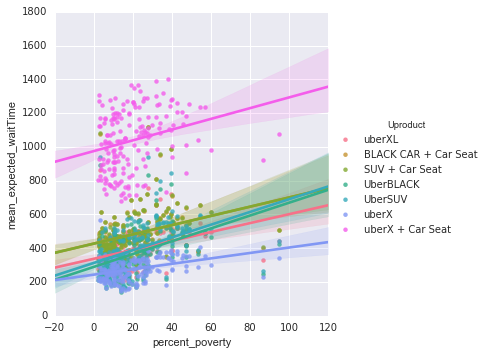

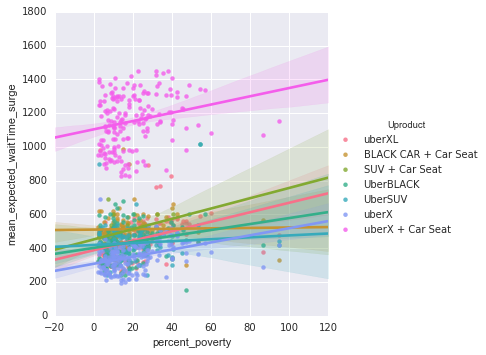

In [82]:
sns.lmplot(y='mean_expected_waitTime', x='percent_poverty', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='mean_expected_waitTime_surge', x='percent_poverty', hue="Uproduct",data=mean_tractsDF_census)

<h3>Poverty Stats Summary</h3>
 <p>These results indicate that areas with higher poverty experience:</p>
   <ul>
    <li>Fewer surges (lower proportion of surge time)</li>
    <li>Longer wait times (expected wait time during a surge or not)</li>
   </ul>  
 <p>These results remain true after removing two 'outlier' tracts</p>

<h2>Race Stats</h2>

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


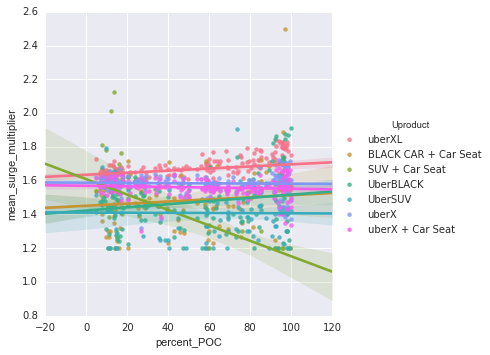

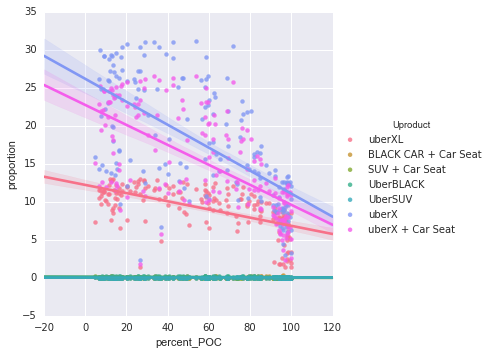

In [83]:
sns.lmplot(y='mean_surge_multiplier', x='percent_POC', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='proportion', x='percent_POC', hue="Uproduct",data=mean_tractsDF_census)

In [84]:
y = mean_tractsDF_census.dropna().proportion[mean_tractsDF_census['Uproduct'] == 'uberX']
x= mean_tractsDF_census.dropna().percent_POC[mean_tractsDF_census['Uproduct'] == 'uberX']

print(pearsonr(x,y))

(-0.64302307814264492, 6.4576215146052552e-22)


/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


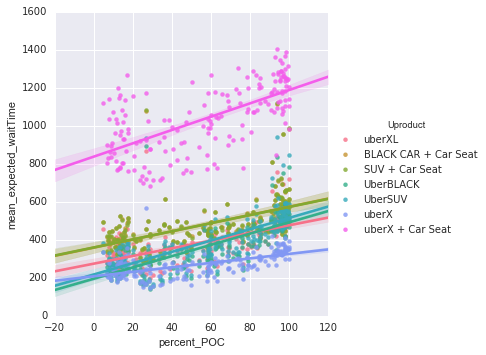

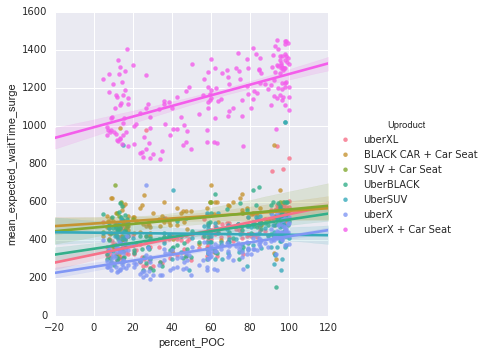

In [85]:
sns.lmplot(y='mean_expected_waitTime', x='percent_POC', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='mean_expected_waitTime_surge', x='percent_POC', hue="Uproduct",data=mean_tractsDF_census)

In [86]:
y = mean_tractsDF_census.dropna().mean_expected_waitTime
x = mean_tractsDF_census.dropna().percent_POC

print(pearsonr(x,y))

(0.25324298201408119, 1.3166598699891927e-14)


<h3>Race/Ethnicity Stats Summary</h3>
 <p>These results indicate that areas with higher proportion of people of color experience:</p>
   <ul>
    <li>Lower proportion of surge time</li>
    <li>Increased wait time</li>
   </ul>  
 <p>Lower propertion of surge time may discourage drivers from going to non-surging neighborhoods. Longer wait times may discourage riders from using Uber. Since supply and demand is a little circular, it is difficult to determine cause for poorer service in these communities.</p>

<h2>Median Household Income Stats</h2>

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


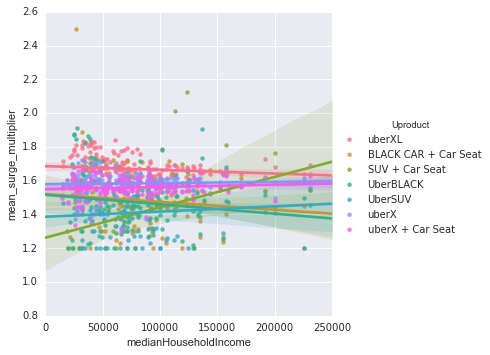

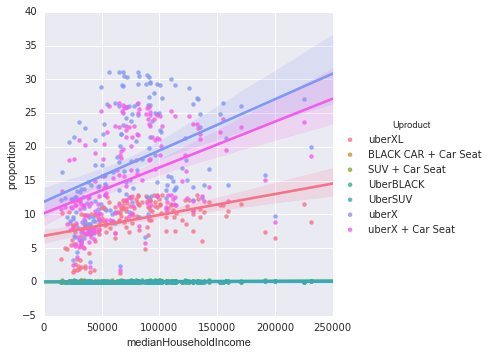

In [87]:
sns.lmplot(y='mean_surge_multiplier', x='medianHouseholdIncome', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='proportion', x='medianHouseholdIncome', hue="Uproduct",data=mean_tractsDF_census)

In [88]:
y = mean_tractsDF_census.dropna().mean_surge_multiplier
x = mean_tractsDF_census.dropna().medianHouseholdIncome

y2 = mean_tractsDF_census.dropna().proportion
x2 = mean_tractsDF_census.dropna().medianHouseholdIncome
print(pearsonr(x,y))
print(pearsonr(x2,y2))

(-0.047586824398911924, 0.15420385980850052)
(0.075806034507266723, 0.023101123542097146)


/Users/jenniferstark/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


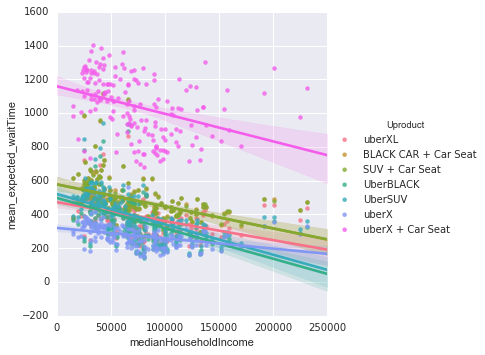

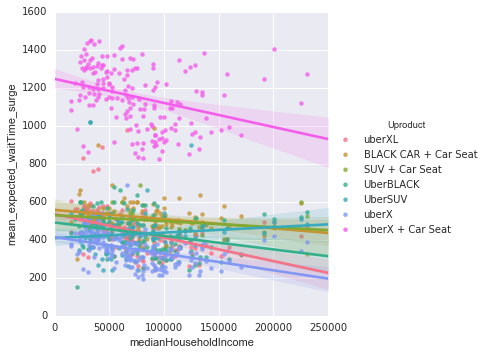

In [89]:
sns.lmplot(y='mean_expected_waitTime', x='medianHouseholdIncome', hue="Uproduct",data=mean_tractsDF_census)
sns.lmplot(y='mean_expected_waitTime_surge', x='medianHouseholdIncome', hue="Uproduct",data=mean_tractsDF_census)

In [90]:
y = mean_tractsDF_census.dropna().mean_expected_waitTime
x = mean_tractsDF_census.dropna().medianHouseholdIncome
print(pearsonr(x,y))

(-0.17025211851381272, 2.8623374412848502e-07)


<h3>Median Household Income Stats Summary</h3>
 <p>These results indicate that areas with higher median household income experience:</p>
   <ul>
    <li>Higher proportion of surge time </li>
    <li>Shorter wait time (regardless of surge)</li>
    </ul>  
 <p>Altogether, surging more often leads to shorter wait times and overal better service to people with higher incomes. Conversely, households with lower median incomes will experience lower surge proportion, and longer wait times.</p>

## Create Database with only uberX 

In [91]:
uberX_census = mean_tractsDF_census[mean_tractsDF_census['Uproduct'] == 'uberX']
uberX_census.head()

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion
5,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,uberX,210.208902,256.759398,1.590044,26.124719
12,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388,uberX,229.042751,289.421289,1.598711,25.828686
19,803422,2.02,11001000202,5425,19.738671,152256.0,87.980664,8.855197,uberX,186.221294,238.488336,1.591788,24.858888
26,1010815,3.00,11001000300,6233,11.992104,135045.0,86.774140,7.715085,uberX,286.138819,352.161046,1.618680,24.820504
33,1532717,4.00,11001000400,1455,9.609013,225179.0,80.812050,14.014407,uberX,282.793039,341.664402,1.618941,27.064315


In [92]:
uberX_census.shape

(179, 13)

## Explore data

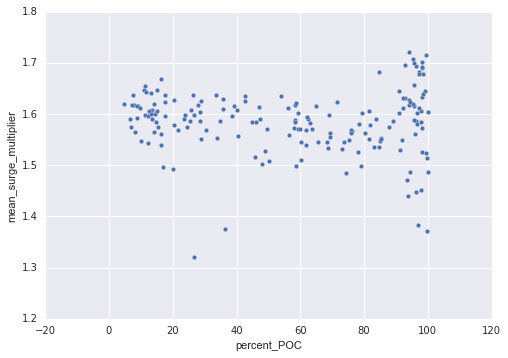

In [93]:
uberX_census.plot(kind='scatter', x='percent_POC', y='mean_surge_multiplier')

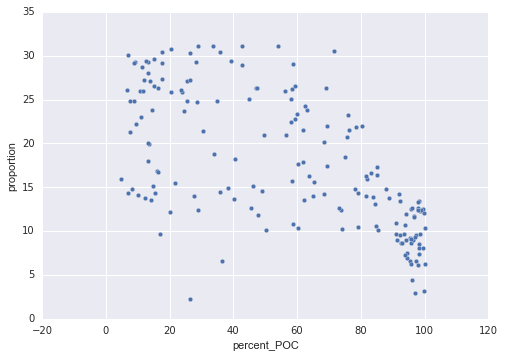

In [94]:
uberX_census.plot(kind='scatter', x='percent_POC', y='proportion')

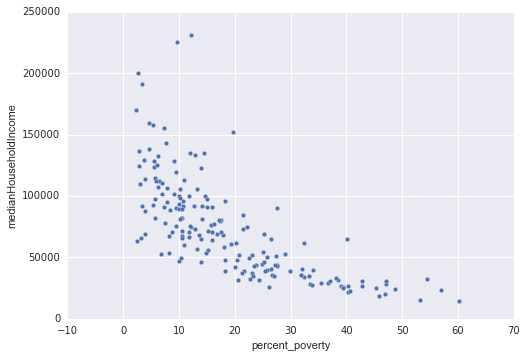

In [95]:
uberX_census.plot(kind='scatter', x='percent_poverty', y='medianHouseholdIncome')

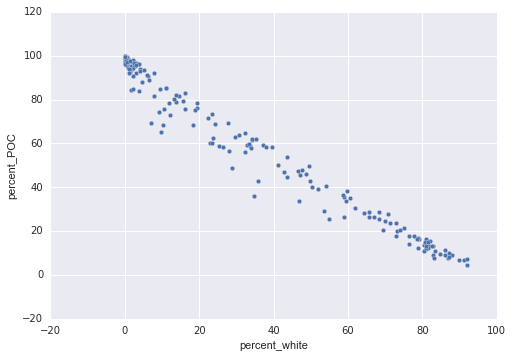

In [96]:
uberX_census.plot(kind='scatter', x='percent_white', y='percent_POC')

## Prepare Data for Statistics

In [97]:
import statsmodels.formula.api as smf  # 'formula' allows one to do like in R

**Calculate population density so that we can control for the idea that places with more people will have better service**

In [98]:
uberX_census['popDensity'] = uberX_census.POP100/uberX_census.AREALAND

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


**Center data and convert to zscores.**

In [99]:
cols = ['percent_POC', 'percent_poverty', 'medianHouseholdIncome', 'proportion', 'mean_expected_waitTime', 'popDensity']
for col in cols:
    col_zscore = col + '_zscore'
    uberX_census[col_zscore] = (uberX_census[col] - uberX_census[col].mean())/uberX_census[col].std()
    

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [100]:
uberX_census.head()

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion,popDensity,percent_POC_zscore,percent_poverty_zscore,medianHouseholdIncome_zscore,proportion_zscore,mean_expected_waitTime_zscore,popDensity_zscore
5,1868613,1.00,11001000100,4890,2.372685,170338.0,91.319444,6.655093,uberX,210.208902,256.759398,1.590044,26.124719,0.002617,-1.541917,-1.167865,2.346700,1.123895,-1.009289,-0.827276
12,542460,2.01,11001000201,3916,86.419753,NaN,71.175858,23.907388,uberX,229.042751,289.421289,1.598711,25.828686,0.007219,-1.015856,4.456719,NaN,1.085282,-0.717051,0.227466
19,803422,2.02,11001000202,5425,19.738671,152256.0,87.980664,8.855197,uberX,186.221294,238.488336,1.591788,24.858888,0.006752,-1.474831,-0.005701,1.906121,0.958787,-1.381497,0.120527
26,1010815,3.00,11001000300,6233,11.992104,135045.0,86.774140,7.715085,uberX,286.138819,352.161046,1.618680,24.820504,0.006166,-1.509596,-0.524116,1.486764,0.953780,0.168891,-0.013791
33,1532717,4.00,11001000400,1455,9.609013,225179.0,80.812050,14.014407,uberX,282.793039,341.664402,1.618941,27.064315,0.000949,-1.317515,-0.683597,3.682935,1.246450,0.116976,-1.209477


## Save dataframe for later

In [101]:
#uberX_census.to_pickle('uberX_census_zscore.pkl')
uberX_census.to_csv('./data/uberX_census_zscore.csv', index=False)

# Statistics: Generalized Linear Model

**Model 1** Looks at '`proportion`' against 'percent people of color', 'median household income', 'percent poverty',
and interactions with 'percent people of color x median household income', and with 'percent people of color x percent
poverty.

**Model 2** Looks at the same as above, but using '`mean expected wait time`' instead of '`proportion`'

In [102]:
mod1 = smf.glm(formula='proportion_zscore ~ percent_POC_zscore + medianHouseholdIncome_zscore + \
               popDensity_zscore + percent_poverty_zscore + percent_POC_zscore:medianHouseholdIncome_zscore + \
               percent_POC_zscore:percent_poverty_zscore', data=uberX_census.dropna()).fit()
mod2 = smf.glm(formula='mean_expected_waitTime_zscore ~ percent_POC_zscore + medianHouseholdIncome_zscore + \
                popDensity_zscore + percent_poverty_zscore + percent_POC_zscore:medianHouseholdIncome_zscore + \
                percent_POC_zscore:percent_poverty_zscore', data=uberX_census.dropna()).fit()
print (mod1.summary())
print (mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      proportion_zscore   No. Observations:                  176
Model:                            GLM   Df Residuals:                      169
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                  0.404317429044
Method:                          IRLS   Log-Likelihood:                -166.47
Date:                Wed, 25 Jan 2017   Deviance:                       68.330
Time:                        18:05:43   Pearson chi2:                     68.3
No. Iterations:                     4                                         
                                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.329

In [103]:
from statsmodels.graphics.api import abline_plot

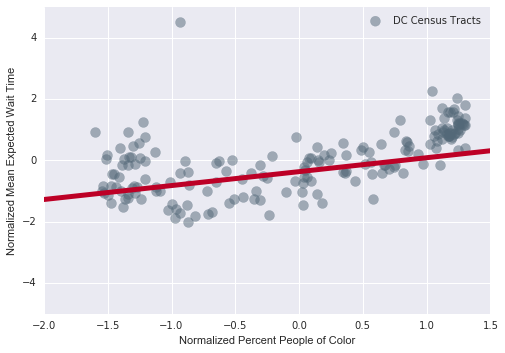

In [104]:
plt.scatter(uberX_census.percent_POC_zscore, uberX_census.mean_expected_waitTime_zscore, color='#536878', \
            alpha=0.5,s=100, label='DC Census Tracts')
plt.legend()

plt.xlabel('Normalized Percent People of Color')
plt.ylabel('Normalized Mean Expected Wait Time')
plt.ylim(-5,5)

abline_plot(intercept=mod2.params['Intercept'],
            slope=mod2.params['percent_POC_zscore'],
            ax=plt.gca(), 
            color='#BD0026',
            linewidth=5)   

plt.savefig('./graphs/POC_MEWT_plain.png')   

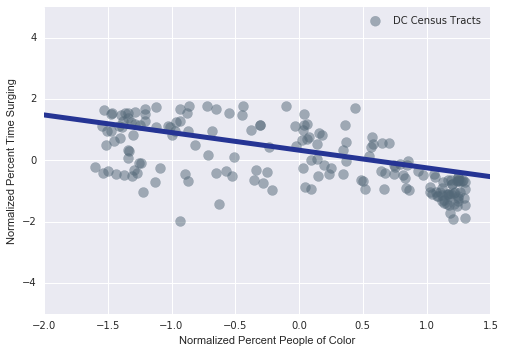

In [105]:
plt.scatter(uberX_census.percent_POC_zscore, uberX_census.proportion_zscore, color='#536878', \
            alpha=0.5, s=100, label='DC Census Tracts')
plt.legend()

plt.xlabel('Normalized Percent People of Color')
plt.ylabel('Normalized Percent Time Surging')
plt.ylim(-5,5)

abline_plot(intercept=mod1.params['Intercept'],
            slope=mod1.params['percent_POC_zscore'],
            ax=plt.gca(), 
            color='#253494',
            linewidth=5)

plt.savefig('./graphs/POC_PROP_plain.png') 

# Statistics: Robust Linear Regression Model due to the outlier observed for Mean Expected Wait Time over a Zscore of 4

In [106]:
mod1b = smf.rlm(formula='proportion_zscore ~ percent_POC_zscore + medianHouseholdIncome_zscore + \
               popDensity_zscore + percent_poverty_zscore + percent_POC_zscore:medianHouseholdIncome_zscore + \
               percent_POC_zscore:percent_poverty_zscore', data=uberX_census.dropna()).fit()
mod2b = smf.rlm(formula='mean_expected_waitTime_zscore ~ percent_POC_zscore + medianHouseholdIncome_zscore + \
                popDensity_zscore + percent_poverty_zscore + percent_POC_zscore:medianHouseholdIncome_zscore + \
                percent_POC_zscore:percent_poverty_zscore', data=uberX_census.dropna()).fit()
print (mod1b.summary())
print (mod2b.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:      proportion_zscore   No. Observations:                  176
Model:                            RLM   Df Residuals:                      169
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Jan 2017                                         
Time:                        18:05:43                                         
No. Iterations:                    21                                         
                                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

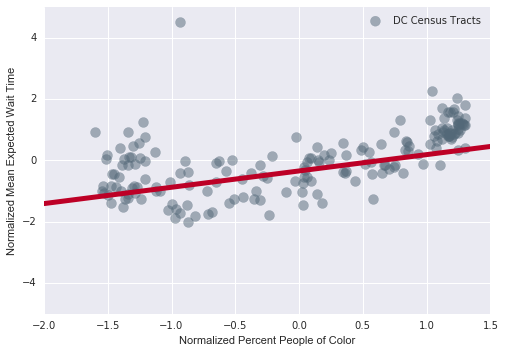

In [107]:
plt.scatter(uberX_census.percent_POC_zscore, uberX_census.mean_expected_waitTime_zscore, color='#536878', \
            alpha=0.5,s=100, label='DC Census Tracts')
plt.legend()

plt.xlabel('Normalized Percent People of Color')
plt.ylabel('Normalized Mean Expected Wait Time')
plt.ylim(-5,5)

abline_plot(intercept=mod2b.params['Intercept'],
            slope=mod2b.params['percent_POC_zscore'],
            ax=plt.gca(), 
            color='#BD0026',
            linewidth=5)   

plt.savefig('./graphs/POC_MEWT_RLM.png')   

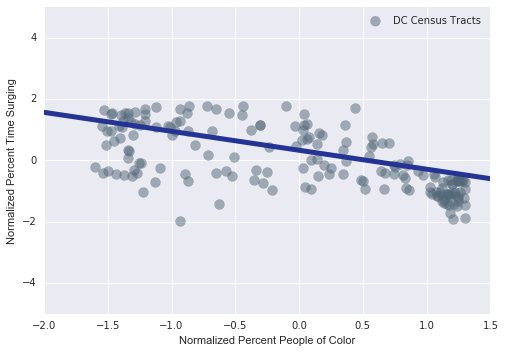

In [108]:
plt.scatter(uberX_census.percent_POC_zscore, uberX_census.proportion_zscore, color='#536878', \
            alpha=0.5, s=100, label='DC Census Tracts')
plt.legend()

plt.xlabel('Normalized Percent People of Color')
plt.ylabel('Normalized Percent Time Surging')
plt.ylim(-5,5)

abline_plot(intercept=mod1b.params['Intercept'],
            slope=mod1b.params['percent_POC_zscore'],
            ax=plt.gca(), 
            color='#253494',
            linewidth=5)

plt.savefig('./graphs/POC_PROP_RLM.png') 

#### What is the mean wait time (minutes) and mean percentage of time spent surging for tracts with the highest proportion of POC and the longest wait times?

In [109]:
uberX_census[(uberX_census.percent_POC > 96) & (uberX_census.mean_expected_waitTime > 376)] 

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion,popDensity,percent_POC_zscore,percent_poverty_zscore,medianHouseholdIncome_zscore,proportion_zscore,mean_expected_waitTime_zscore,popDensity_zscore
1048,1884942,96.01,11001009601,2445,42.824181,26607.0,0.183318,97.158570,uberX,383.484831,473.455919,1.611131,6.621473,0.001297,1.217737,1.539223,-1.155395,-1.419995,1.679378,-1.129758
1097,531058,98.03,11001009803,2758,39.417122,25500.0,0.178699,99.821301,uberX,391.470223,520.869565,1.371014,3.210298,0.005193,1.298929,1.311217,-1.182368,-1.864929,1.803285,-0.236771
1111,1037014,98.07,11001009807,3072,34.054742,39758.0,2.478315,96.871128,uberX,376.020772,505.263158,1.382632,2.945280,0.002962,1.208972,0.952356,-0.834963,-1.899496,1.563560,-0.748105
1118,398420,98.10,11001009810,2507,36.763519,28922.0,0.160321,96.152305,uberX,376.269357,503.978873,1.446831,4.442359,0.006292,1.187054,1.133633,-1.098989,-1.704226,1.567418,0.015097
1237,2379832,109.00,11001010900,3211,54.369170,32092.0,1.355276,97.797677,uberX,407.092609,515.001738,1.450907,6.087727,0.001349,1.237225,2.311835,-1.021750,-1.489614,2.045692,-1.117810


In [110]:
print(uberX_census[(uberX_census.percent_POC > 96) & (uberX_census.mean_expected_waitTime > 376)].mean_expected_waitTime.mean()/60, " minutes")
print(uberX_census[(uberX_census.percent_POC > 96) & (uberX_census.mean_expected_waitTime > 376)].proportion.mean(), " % time surging")

6.447792640371472  minutes
4.66142714326163  % time surging


#### What is the mean wait time (minutes) and mean percentage of time spent surging for tracts with the lowest proportion of POC and the shortest wait times?

In [111]:
uberX_census[(uberX_census.percent_POC < 20) & (uberX_census.mean_expected_waitTime < 195)] 

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion,popDensity,percent_POC_zscore,percent_poverty_zscore,medianHouseholdIncome_zscore,proportion_zscore,mean_expected_waitTime_zscore,popDensity_zscore
19,803422,2.02,11001000202,5425,19.738671,152256.0,87.980664,8.855197,uberX,186.221294,238.488336,1.591788,24.858888,0.006752,-1.474831,-0.005701,1.906121,0.958787,-1.381497,0.120527
432,207646,42.02,11001004202,2771,8.364591,88750.0,81.086957,12.500000,uberX,194.314650,237.694130,1.605844,29.369927,0.013345,-1.363693,-0.766876,0.358758,1.547181,-1.255915,1.631449
516,339712,52.01,11001005201,6077,9.030043,101789.0,78.952790,12.068670,uberX,176.457222,231.516010,1.596798,27.274132,0.017889,-1.376845,-0.722342,0.676461,1.273817,-1.533003,2.672853


In [112]:
print(uberX_census[(uberX_census.percent_POC < 20) & (uberX_census.mean_expected_waitTime < 195)].mean_expected_waitTime.mean()/60, " minutes")
print(uberX_census[(uberX_census.percent_POC < 20) & (uberX_census.mean_expected_waitTime < 195)].proportion.mean(), " % time surging")

3.094406482712418  minutes
27.16764904642083  % time surging


#### The average wait time in Northwest DC tracts :

In [113]:
NW_DC_tracts = (uberX_census[(uberX_census.BASENAME == 10.02) | # Tenelytown / cathedral heights
     (uberX_census.BASENAME == 56) |    # Foggy Bottom
     (uberX_census.BASENAME == 7.01) |  # Cathedral Heights
     (uberX_census.BASENAME == 12) |    # Tenelytown
     (uberX_census.BASENAME == 5.01)])   # Zoo, Woodley Park
NW_DC_tracts

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion,popDensity,percent_POC_zscore,percent_poverty_zscore,medianHouseholdIncome_zscore,proportion_zscore,mean_expected_waitTime_zscore,popDensity_zscore
40,940549,5.01,11001000501,3376,9.957369,100109.0,82.772984,9.193692,uberX,245.922827,302.831389,1.614979,29.226716,0.003589,-1.464510,-0.660284,0.635527,1.528501,-0.455128,-0.604394
61,548945,7.01,11001000701,4620,7.429335,78040.0,83.365164,10.828877,uberX,240.614477,308.967780,1.647464,26.006672,0.008416,-1.414649,-0.829465,0.097802,1.108497,-0.537496,0.501847
110,889584,10.02,11001001002,3442,27.510669,90221.0,79.180887,16.240046,uberX,280.299766,344.817345,1.669260,26.284153,0.003869,-1.249650,0.514415,0.394600,1.144690,0.078288,-0.540259
124,1218245,12.00,11001001200,5008,6.946721,101628.0,84.610656,9.590164,uberX,247.298599,318.260172,1.612430,22.224588,0.004111,-1.452420,-0.861762,0.672538,0.615184,-0.433780,-0.484886
537,464182,56.00,11001005600,6756,17.511805,70977.0,74.062066,20.379805,uberX,211.179971,256.066946,1.578452,25.855807,0.014555,-1.123420,-0.154727,-0.074292,1.088819,-0.994222,1.908725


In [114]:
print(NW_DC_tracts.mean_expected_waitTime.mean(), " seconds")   

245.063127891188  seconds


#### What is the range for the proportion of time DC tracts spent surging?

In [115]:
minimum, maximum = uberX_census.proportion.min(), uberX_census.proportion.max()
print("Tracts surged anywhere between {0} and {1} percent of the time".format(minimum, maximum))

Tracts surged anywhere between 2.303102375020303 and 31.120749748276666 percent of the time


#### Edgewood has high % POC but a mean wait time within the 50th percentile.

In [116]:
uberX_census[uberX_census.BASENAME == 92.03]

,AREALAND,BASENAME,GEOID,POP100,percent_poverty,medianHouseholdIncome,percent_white,percent_POC,Uproduct,mean_expected_waitTime,mean_expected_waitTime_surge,mean_surge_multiplier,proportion,popDensity,percent_POC_zscore,percent_poverty_zscore,medianHouseholdIncome_zscore,proportion_zscore,mean_expected_waitTime_zscore,popDensity_zscore
964,581089,92.03,11001009203,2582,16.810967,68750.0,16.305916,75.865801,uberX,245.861242,309.450549,1.56983,23.226854,0.004443,0.568473,-0.201629,-0.128555,0.745914,-0.456083,-0.408669


In [117]:
print("Edgewood has {0} % POC and a mean expected wait time of {1}".format(uberX_census[uberX_census.BASENAME == 92.03]
                                                                           .percent_POC.values, 
                                                                           uberX_census[uberX_census.BASENAME == 92.03].
                                                                           mean_expected_waitTime.values))

Edgewood has [ 75.86580087] % POC and a mean expected wait time of [ 245.86124217]


In [118]:
print("The mean expected wait time across all tracts is", uberX_census.mean_expected_waitTime.mean())

The mean expected wait time across all tracts is 275.2543449666452
